In [ ]:
! pip install evaluate transformers==4.52.1 rouge-score nltk
! pip install -U datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Transformers/Project')

In [ ]:
from datasets import load_dataset
from evaluate import load

raw_datasets = load_dataset("xsum")
metric = load("rouge")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
raw_datasets["train"] = raw_datasets["train"].shuffle(seed=42).select(range(1000))
raw_datasets["validation"] = raw_datasets["validation"].shuffle(seed=42).select(range(1000))
raw_datasets["test"] = raw_datasets["test"].shuffle(seed=42).select(range(1000))

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "google/t5-v1_1-small"
fp16_problem = False

if model_checkpoint.startswith("google/t5-v1_1"):
  fp16_problem = True
  print("This model has a problem with fp16, we will apply a fix later on.")

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

This model has a problem with fp16, we will apply a fix later on.


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
max_input_length = 1024
max_target_length = 128
prefix = "summarize: "

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["document"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    labels = tokenizer(text_target=examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
import torch
from torch import nn
from safetensors.torch import load_file
from T5_to_GQA import convert_t5_to_gqa, T5GQAAttention
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

kv_heads = 6
n_heads = 6

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
convert_t5_to_gqa(model.decoder, kv_heads=kv_heads, inplace=True)
model.eval()

# **Cosine simelarity between input after heads w_k**
By generating inputs.

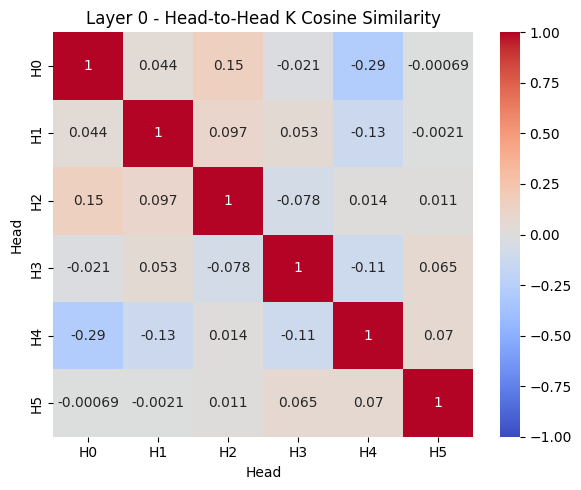

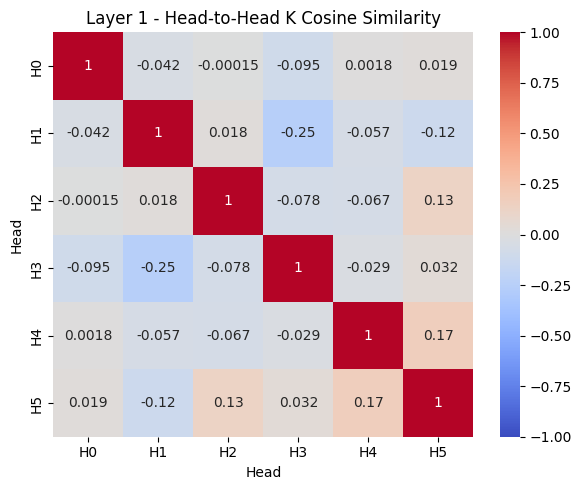

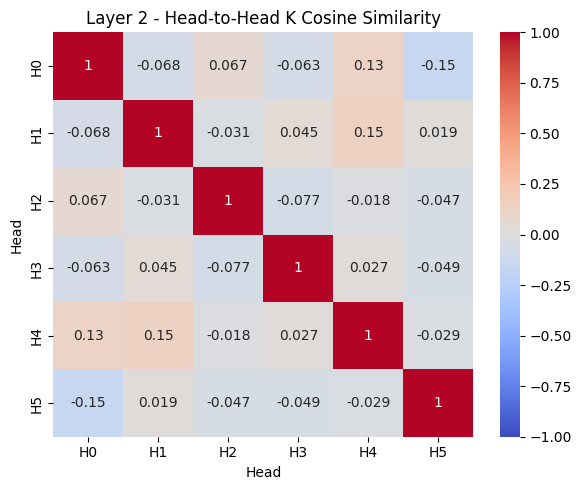

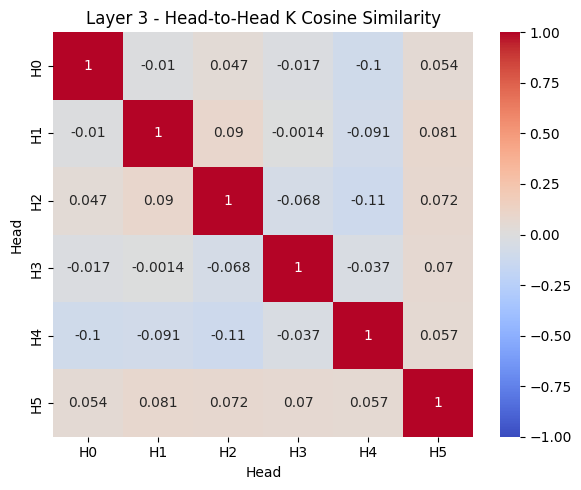

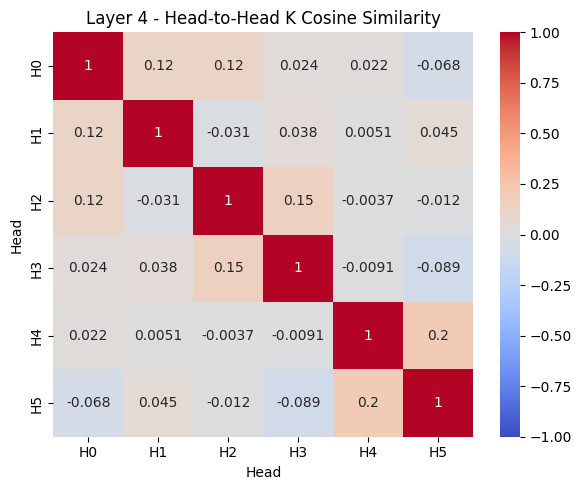

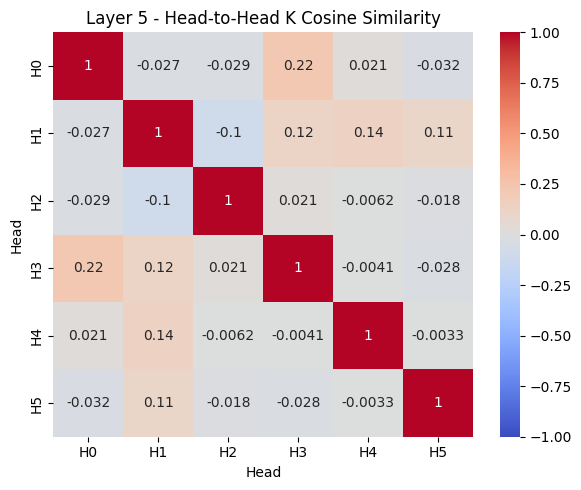

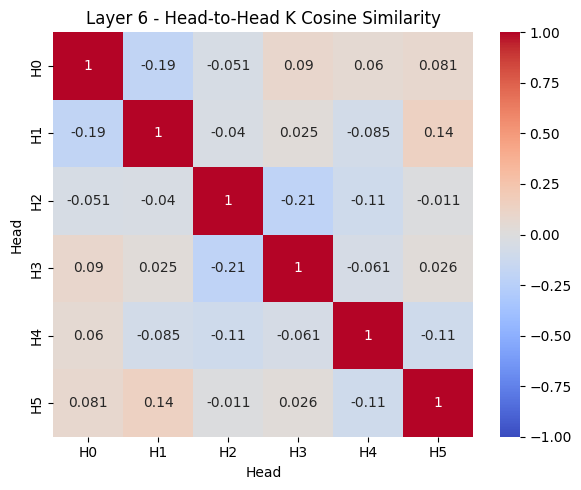

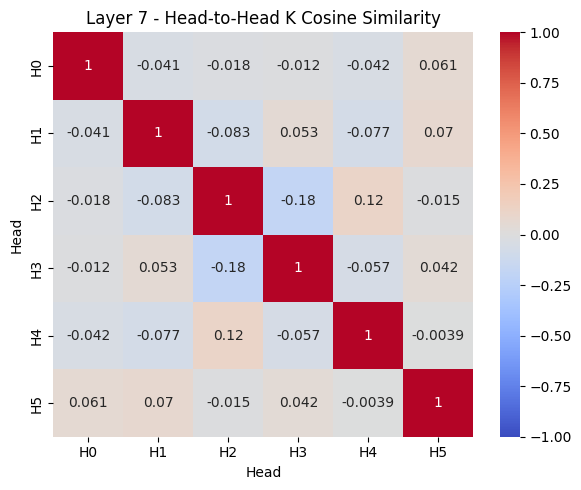

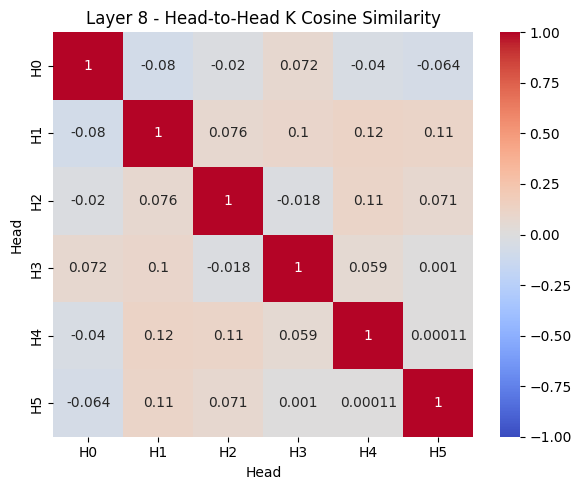

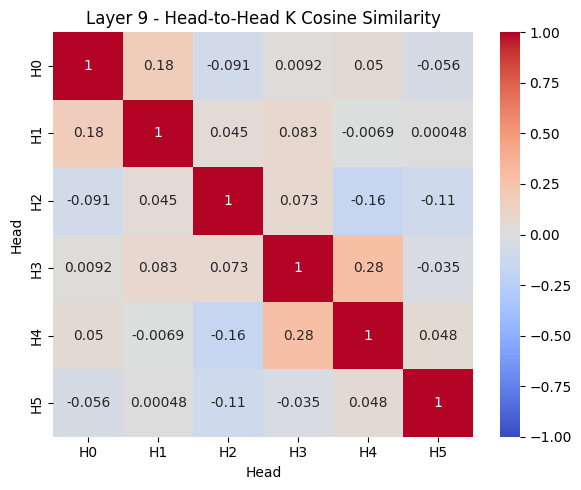

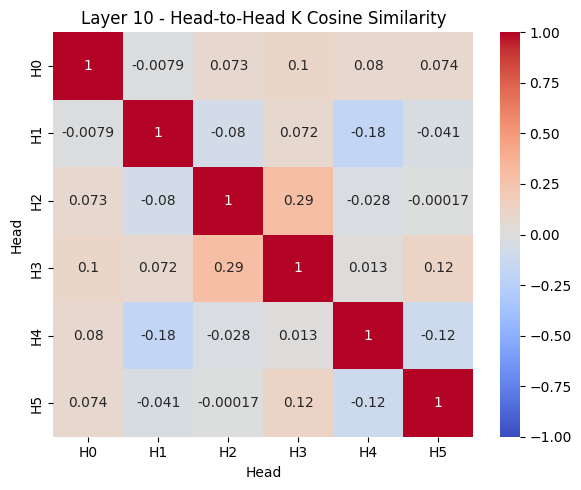

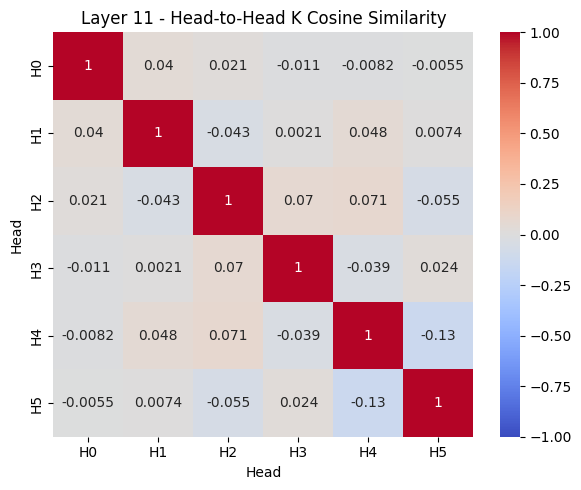

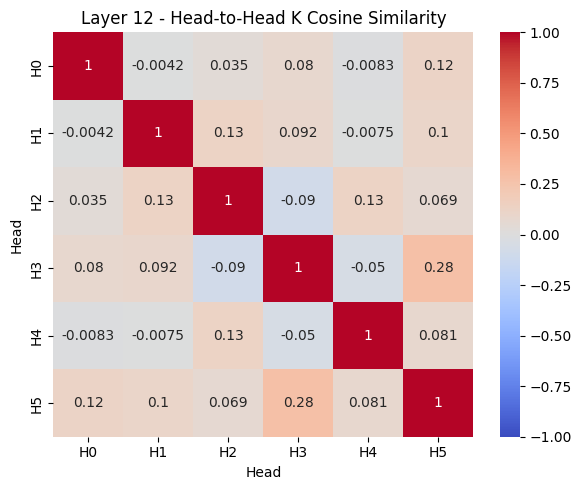

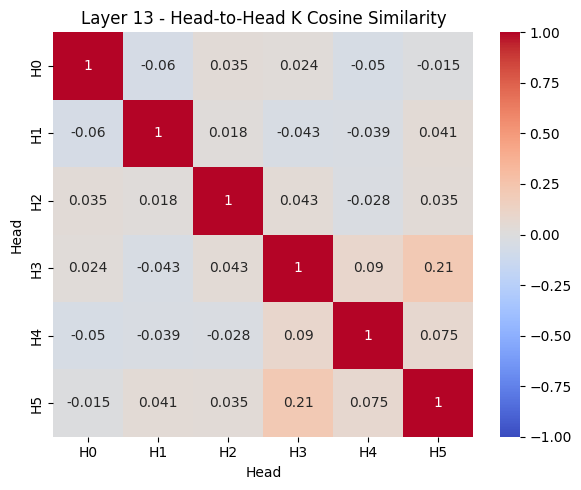

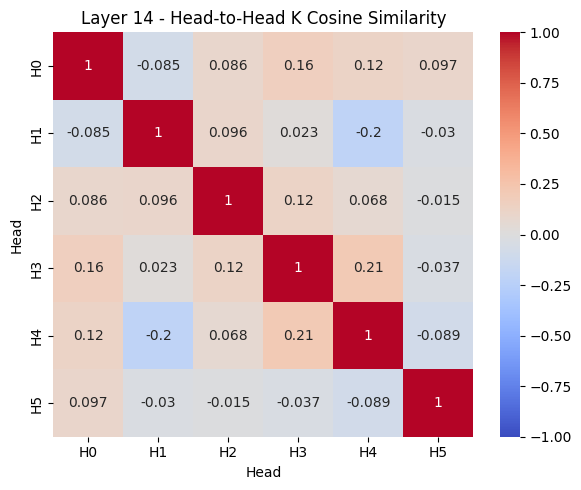

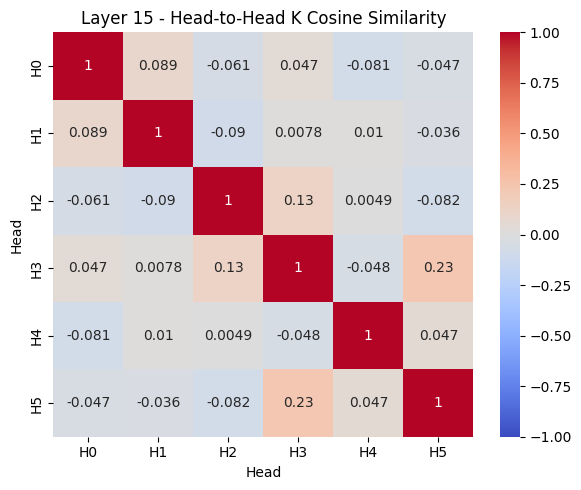

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

def plot_layer_head_similarity(q_outputs, layer_idx):
    for _, q_proj in enumerate(q_outputs):
        q_proj = q_proj.squeeze(0)  # (n_heads, seq_len, d_kv)
        n_heads, seq_len, d_kv = q_proj.shape

        sim_matrix = torch.zeros((n_heads, n_heads))

        for t in range(seq_len):
            q_vectors = q_proj[:, t, :]  # (n_heads, d_kv)
            q_norm = F.normalize(q_vectors, dim=1)  # normalize each head's vector

            cos_sim = torch.matmul(q_norm, q_norm.T)  # → (n_heads, n_heads)
            sim_matrix += cos_sim

        # Average across sequence length
        sim_matrix /= seq_len
        sim_matrix_np = sim_matrix.detach().numpy()

        plt.figure(figsize=(6, 5))
        sns.heatmap(sim_matrix_np, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
                    xticklabels=[f"H{i}" for i in range(n_heads)],
                    yticklabels=[f"H{i}" for i in range(n_heads)])
        plt.title(f"Layer {layer_idx} - Head-to-Head K Cosine Similarity")
        plt.xlabel("Head")
        plt.ylabel("Head")
        plt.tight_layout()
        plt.show()

def close_wk(t5: T5GQAAttention, kv_heads: int, layer_idx):
    # d_model -> n_heads*d_kv.
    q_matrix = t5.q.weight.data
    # d_model -> kv_heads*d_kv.
    k_w, v_w = t5.k.weight.data, t5.v.weight.data

    k_proj = nn.Linear(k_w.shape[1], k_w.shape[0], bias=False)
    k_proj.weight.data = k_w
    d_kv = k_w.shape[0] // kv_heads

    outputs = k_proj(torch.rand(1, 5000, 512))
    outputs = outputs.view(outputs.shape[0], -1, n_heads, d_kv).transpose(1, 2)

    # Calculate cosine similarity between the heads on same input.
    plot_layer_head_similarity(outputs, layer_idx)

layer_idx = 0

for name, module in model.decoder.named_modules():
  if isinstance(module, T5GQAAttention):
    close_wk(module, kv_heads, layer_idx)
    layer_idx += 1

# **Cosine simelarity**
By sampling input from the validation set of XSum.

In [ ]:
def calculate_model_wk(model, input_ids, attention_mask):
  k_out = []
  def capture_k_hook(module, input, output):
      # input[0] shape - (batch, seq_len, d_model)
      hidden_states = input[0]
      proj = torch.nn.functional.linear(hidden_states, module.k.weight, module.k.bias if module.k.bias is not None else None)
      k_out.append(proj.detach())

  hooks = []
  def register_hooks(module):
      if isinstance(module, T5GQAAttention):
          hooks.append(module.register_forward_hook(capture_k_hook))

  for name, module in model.decoder.named_modules():
      register_hooks(module)

  with torch.no_grad():
      model(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=input_ids)

  for h in hooks:
      h.remove()

  d_kv = k_out[0].shape[2] // kv_heads
  print(f"Captured {len(k_out)} layers of k projections to {d_kv} dim for each head.")

  for idx in range(len(k_out)):
    k_out[idx] = k_out[idx].view(k_out[idx].shape[0], -1, n_heads, d_kv).transpose(1, 2)

  print("Shape of first k projection:", k_out[0].shape)  # (1, num_heads, seq_len, head_dim)
  return k_out


In [ ]:
final_out = []

for idx in range(1):
  sample = tokenized_datasets["validation"][idx]
  input_ids = torch.tensor(sample["input_ids"]).unsqueeze(0)
  attention_mask = torch.tensor(sample["attention_mask"]).unsqueeze(0)
  k_out = calculate_model_wk(model, input_ids, attention_mask)
  if final_out == []:
    final_out = k_out
  else:
    for j in range(len(k_out)):
      final_out[j] = torch.cat((final_out[j], k_out[j]), dim=2)

final_out[0].shape

Captured 16 layers of k projections to 64 dim for each head.
Shape of first k projection: torch.Size([1, 6, 728, 64])


torch.Size([1, 6, 728, 64])

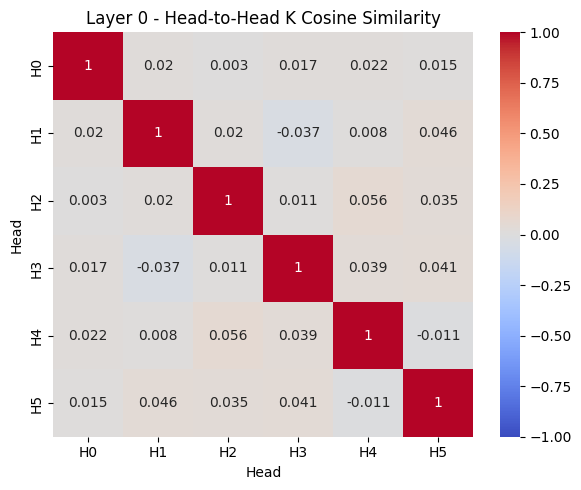

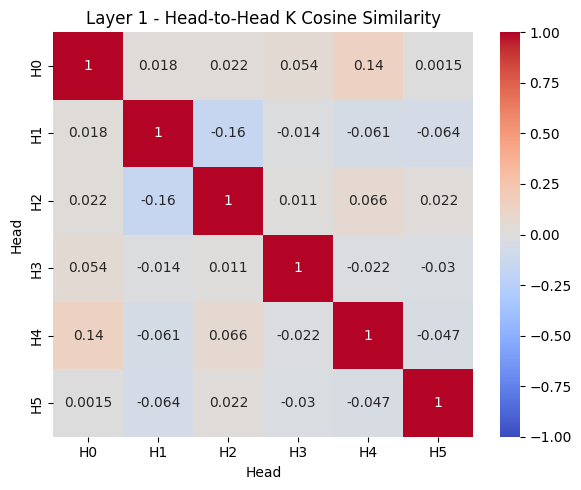

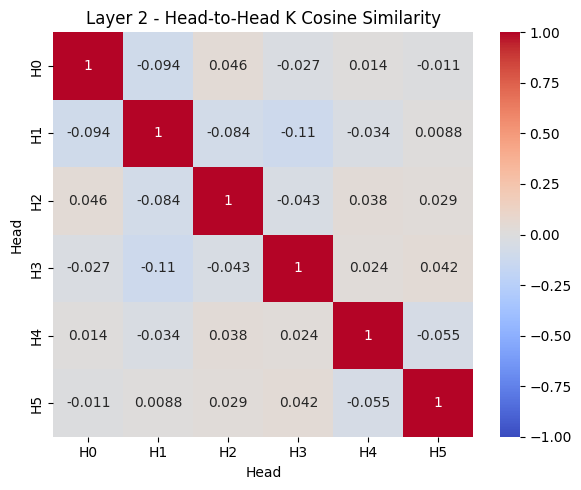

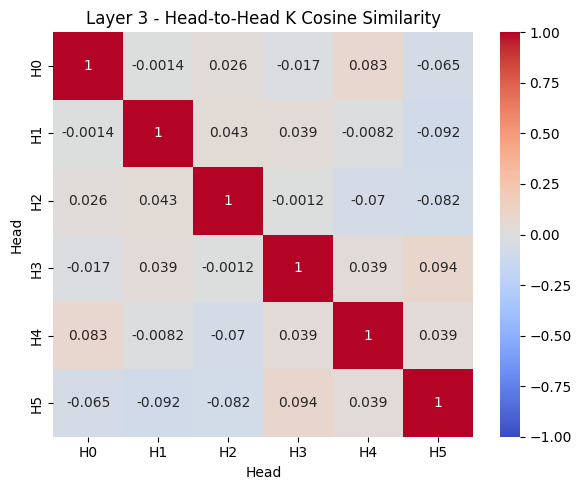

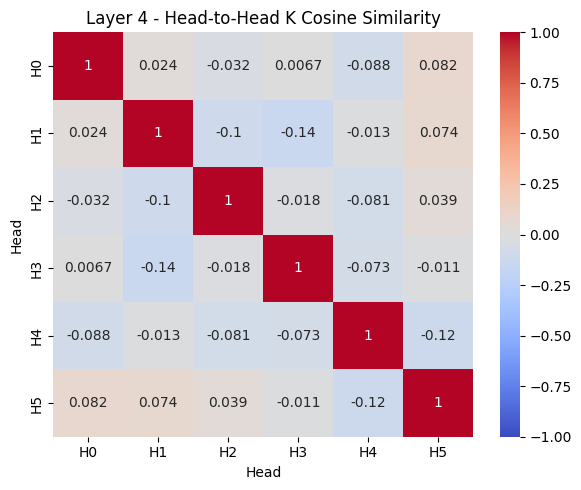

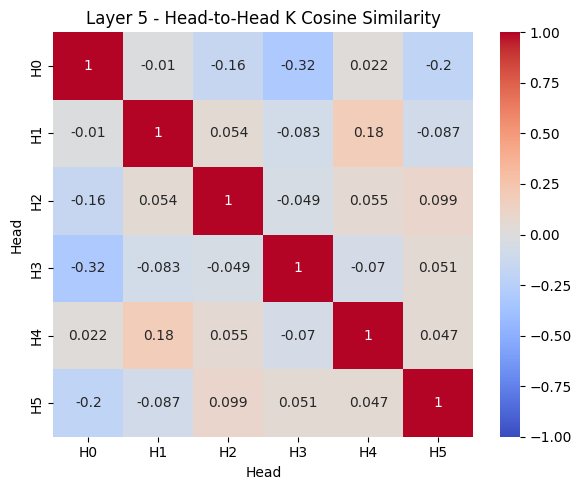

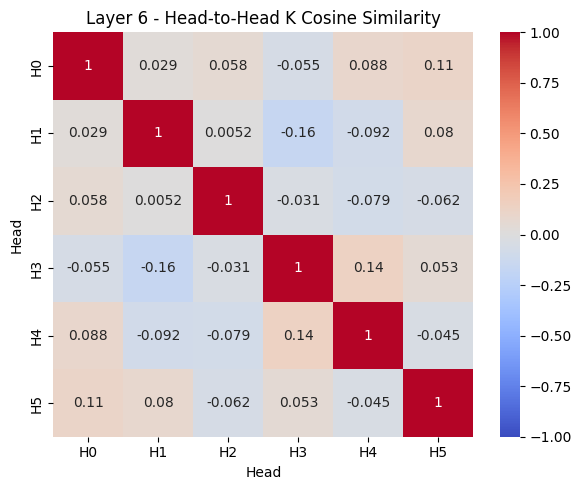

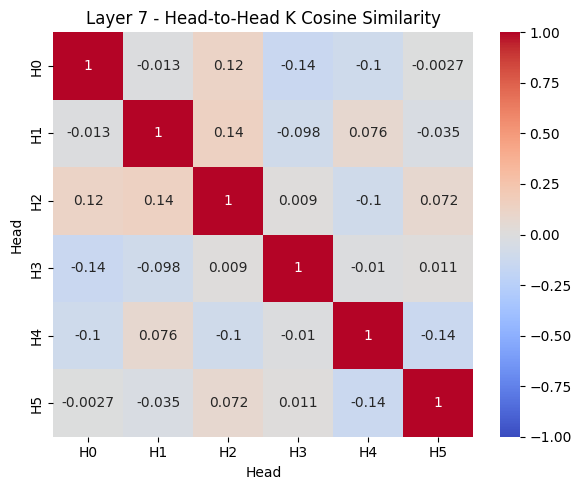

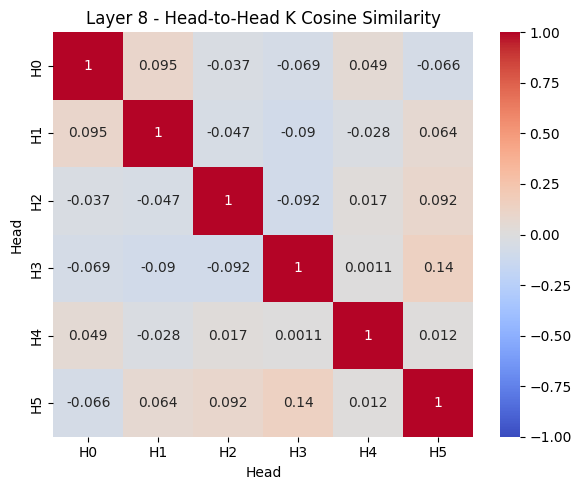

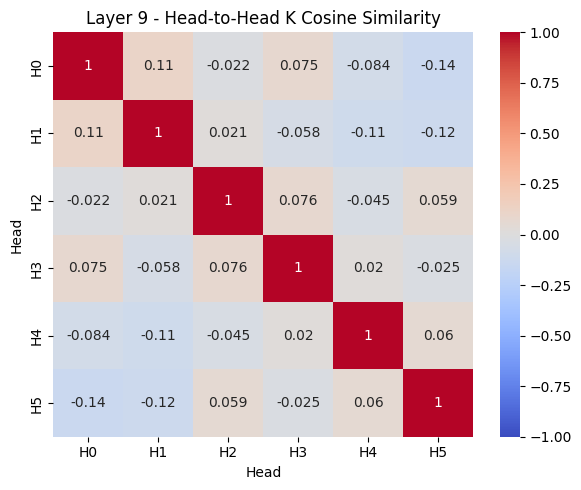

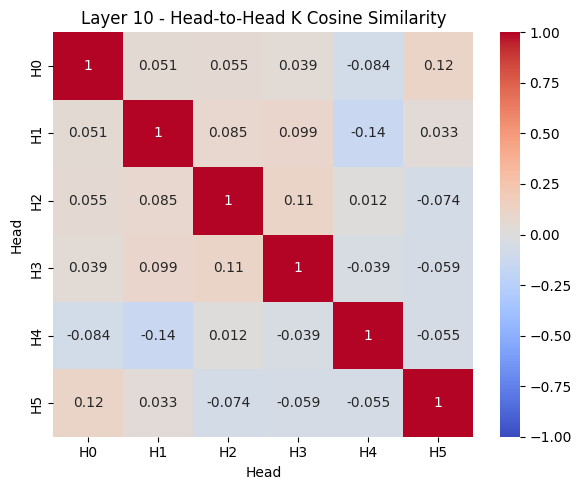

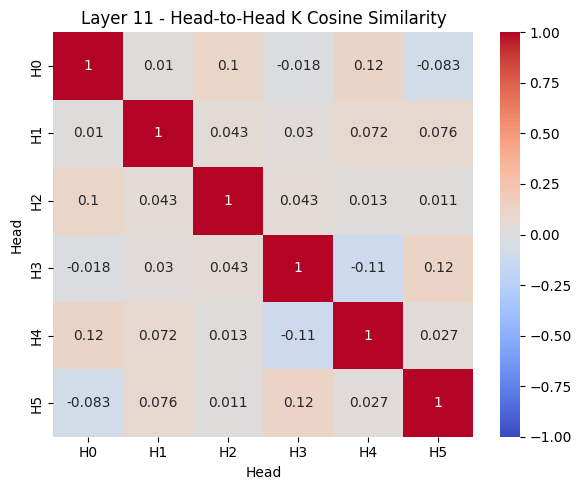

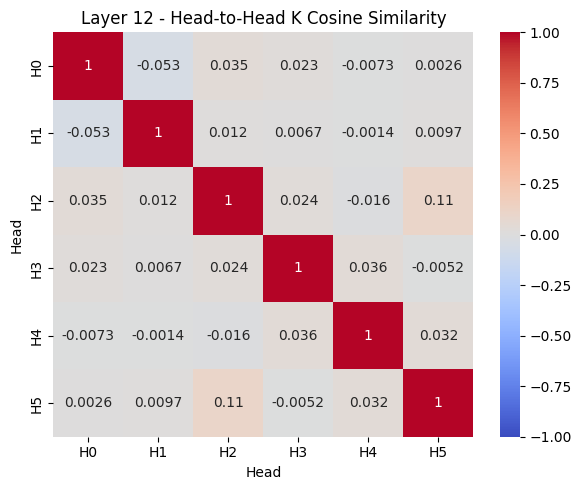

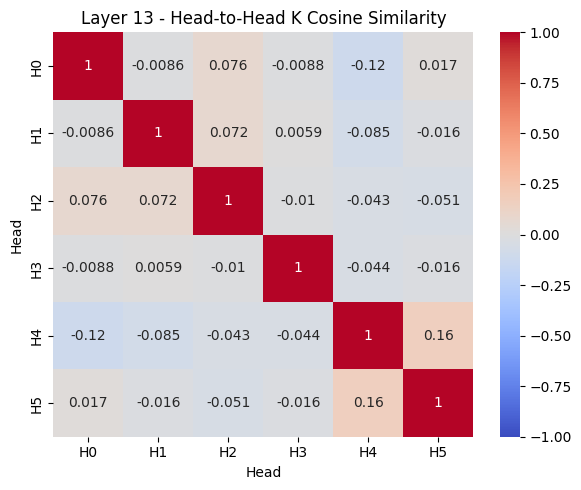

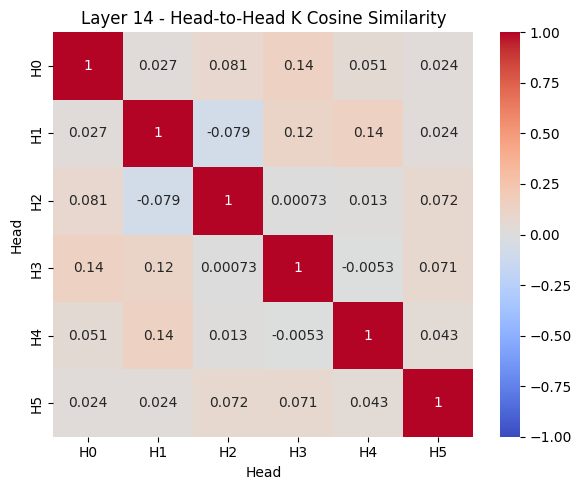

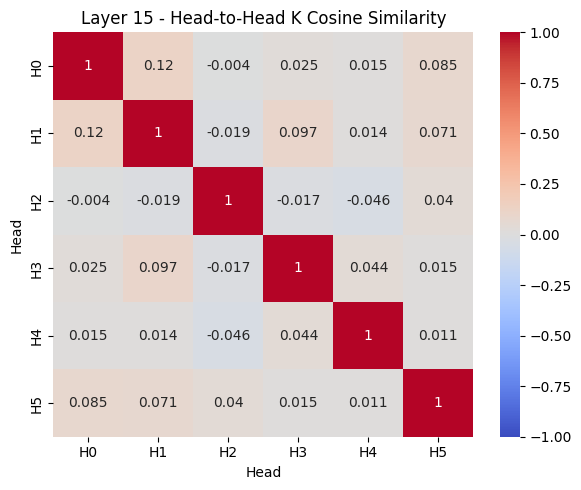

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

def plot_layer_head_similarity(outs):
    for layer_idx, k_proj in enumerate(outs):
        k_proj = k_proj.squeeze(0)  # (n_heads, seq_len, d_kv)
        n_heads, seq_len, d_kv = k_proj.shape

        sim_matrix = torch.zeros((n_heads, n_heads))

        for t in range(seq_len):
            k_vectors = k_proj[:, t, :]  # (n_heads, d_kv)
            k_norm = F.normalize(k_vectors, dim=1)  # normalize each head's vector

            cos_sim = torch.matmul(k_norm, k_norm.T)  # → (n_heads, n_heads)
            sim_matrix += cos_sim

        # Average across sequence length
        sim_matrix /= seq_len
        sim_matrix_np = sim_matrix.cpu().numpy()

        plt.figure(figsize=(6, 5))
        sns.heatmap(sim_matrix_np, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
                    xticklabels=[f"H{i}" for i in range(n_heads)],
                    yticklabels=[f"H{i}" for i in range(n_heads)])
        plt.title(f"Layer {layer_idx} - Head-to-Head K Cosine Similarity")
        plt.xlabel("Head")
        plt.ylabel("Head")
        plt.tight_layout()
        plt.show()

plot_layer_head_similarity(final_out)

# **Test grouping by close attention score**

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

def calc_sim_matrix(outs):
  layers_sim = []
  for layer_idx, score in enumerate(outs):
    score = score.squeeze(0)  # (n_heads, seq_len, d_kv)
    n_heads, seq_len, d_kv = score.shape

    sim_matrix = torch.zeros((n_heads, n_heads))

    for t in range(seq_len):
        score_vectors = score[:, t, :]  # (n_heads, d_kv)
        score_norm = F.normalize(score_vectors, dim=1)  # normalize each head's vector

        cos_sim = torch.matmul(score_norm, score_norm.T)  # (n_heads, n_heads)
        sim_matrix += cos_sim

    # Average across sequence length
    sim_matrix /= seq_len
    sim_matrix_np = sim_matrix.cpu().numpy()
    layers_sim.append(sim_matrix_np)

  return layers_sim


def plot_layer_head_score_similarity(outs):
    # sim_matrixs = calc_sim_matrix(outs)

    for layer_idx, sim_mat in enumerate(outs):
        plt.figure(figsize=(6, 5))
        sns.heatmap(sim_mat, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
                    xticklabels=[f"H{i}" for i in range(n_heads)],
                    yticklabels=[f"H{i}" for i in range(n_heads)])
        plt.title(f"Layer {layer_idx} - Head-to-Head K Cosine Similarity")
        plt.xlabel("Head")
        plt.ylabel("Head")
        plt.tight_layout()
        plt.show()


def calculate_model_score(model, input_ids, attention_mask):
  score_out = []
  def capture_k_hook(module, input, output):
      # input[0] shape - (batch, seq_len, d_model)
      hidden_states = input[0]
      k_proj = torch.nn.functional.linear(hidden_states, module.k.weight, module.k.bias if module.k.bias is not None else None)
      q_proj = torch.nn.functional.linear(hidden_states, module.q.weight, module.q.bias if module.q.bias is not None else None)

      d_kv = k_proj.shape[2] // n_heads
      q_proj = q_proj.view(q_proj.shape[0], -1, n_heads, d_kv).transpose(1, 2)
      k_proj = k_proj.view(k_proj.shape[0], -1, n_heads, d_kv).transpose(1, 2)

      # score shape - (batch, n_heads, seq_len, seq_len)
      score = torch.matmul(q_proj, k_proj.transpose(3, 2))
      score_out.append(score.detach())

  hooks = []
  def register_hooks(module):
      if isinstance(module, T5GQAAttention):
          hooks.append(module.register_forward_hook(capture_k_hook))

  for name, module in model.decoder.named_modules():
      register_hooks(module)

  with torch.no_grad():
      model(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=input_ids)

  for h in hooks:
      h.remove()

  print("Shape of first layer score:", score_out[0].shape)  # (1, num_heads, seq_len, head_dim)
  return score_out


Shape of first layer score: torch.Size([1, 6, 409, 409])
Shape of first layer score: torch.Size([1, 6, 626, 626])
Shape of first layer score: torch.Size([1, 6, 89, 89])
Shape of first layer score: torch.Size([1, 6, 344, 344])
Shape of first layer score: torch.Size([1, 6, 289, 289])
Shape of first layer score: torch.Size([1, 6, 361, 361])
Shape of first layer score: torch.Size([1, 6, 386, 386])
Shape of first layer score: torch.Size([1, 6, 267, 267])
Shape of first layer score: torch.Size([1, 6, 933, 933])
Shape of first layer score: torch.Size([1, 6, 89, 89])
Shape of first layer score: torch.Size([1, 6, 1024, 1024])
Shape of first layer score: torch.Size([1, 6, 565, 565])
Shape of first layer score: torch.Size([1, 6, 303, 303])
Shape of first layer score: torch.Size([1, 6, 175, 175])
Shape of first layer score: torch.Size([1, 6, 307, 307])
Shape of first layer score: torch.Size([1, 6, 294, 294])
Shape of first layer score: torch.Size([1, 6, 559, 559])
Shape of first layer score: torch

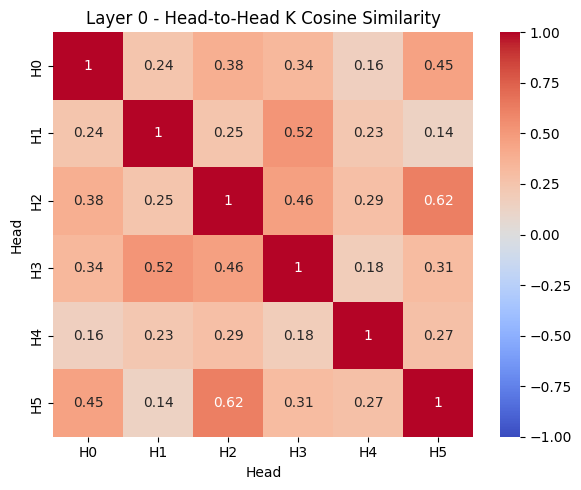

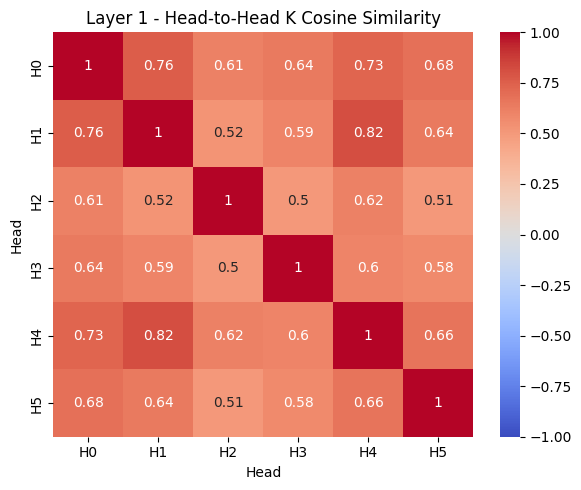

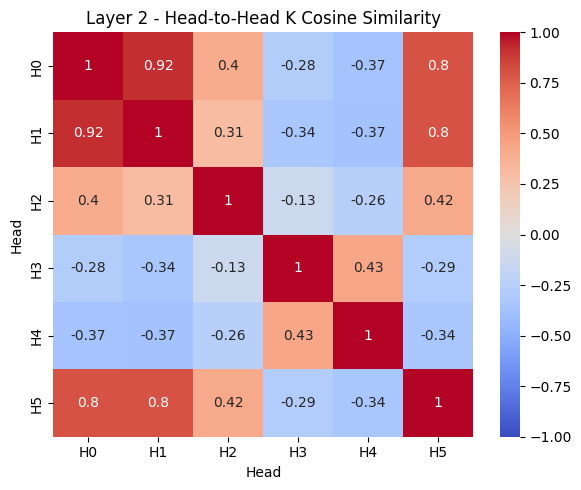

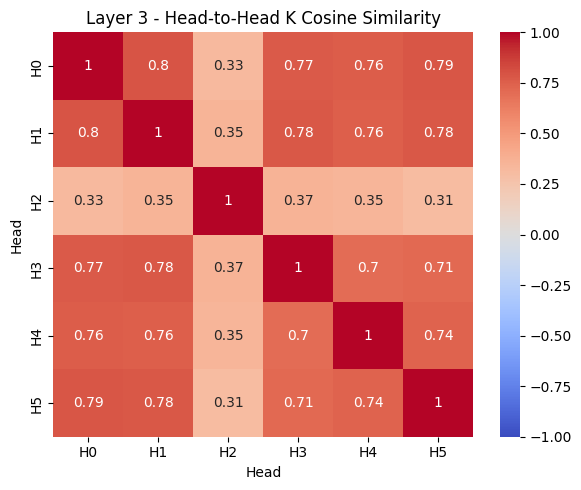

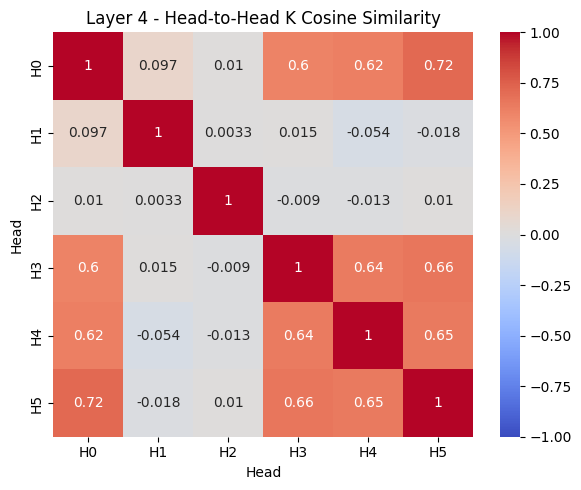

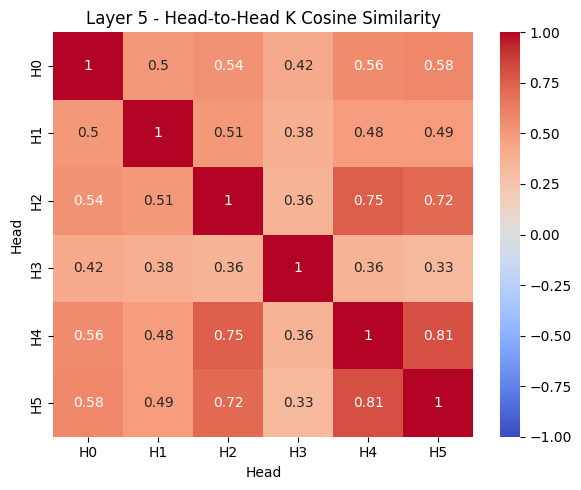

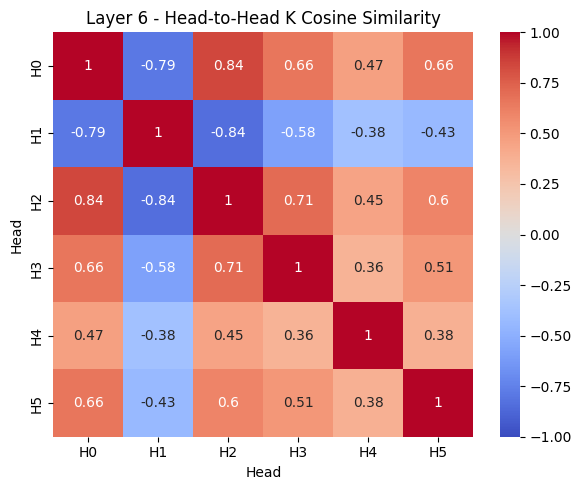

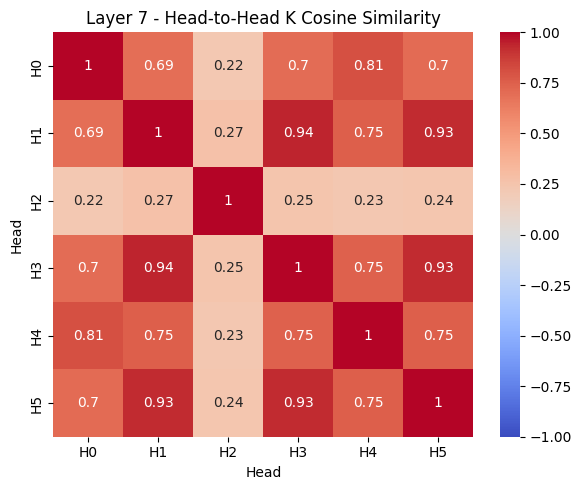

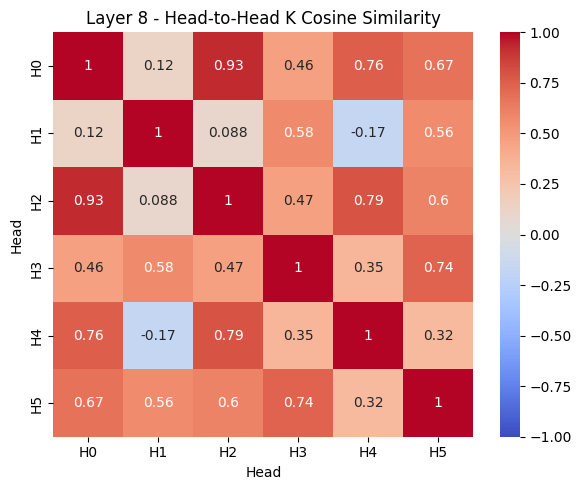

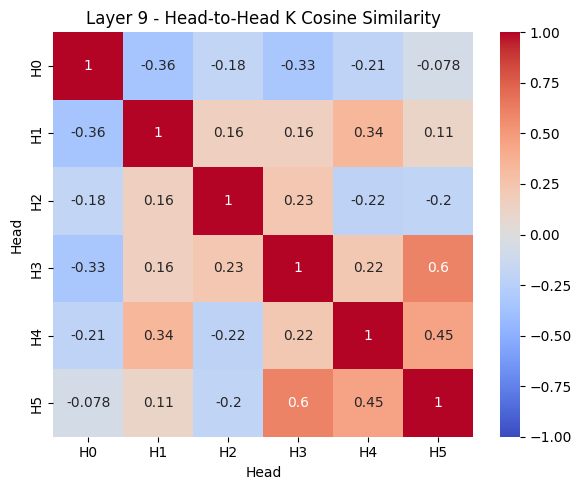

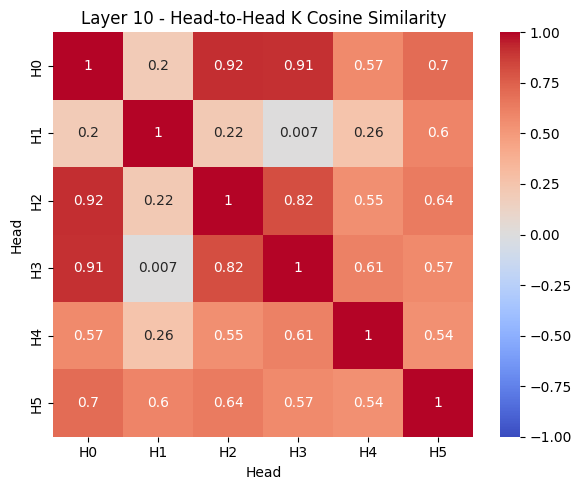

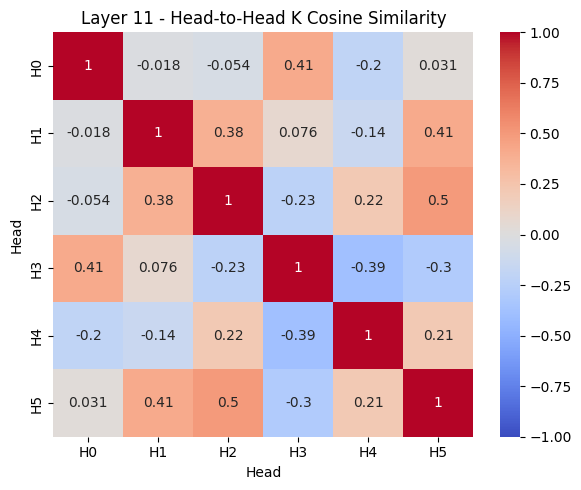

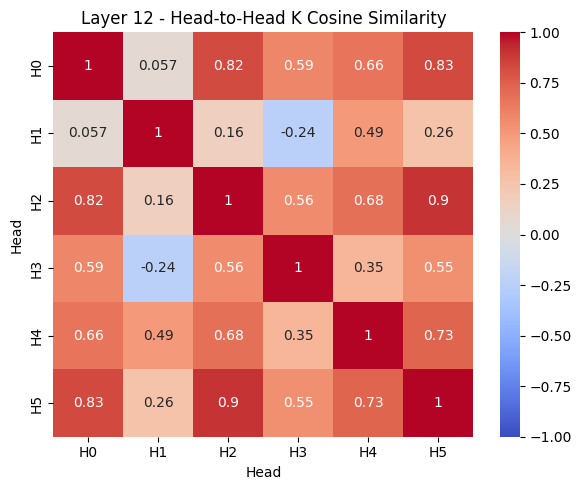

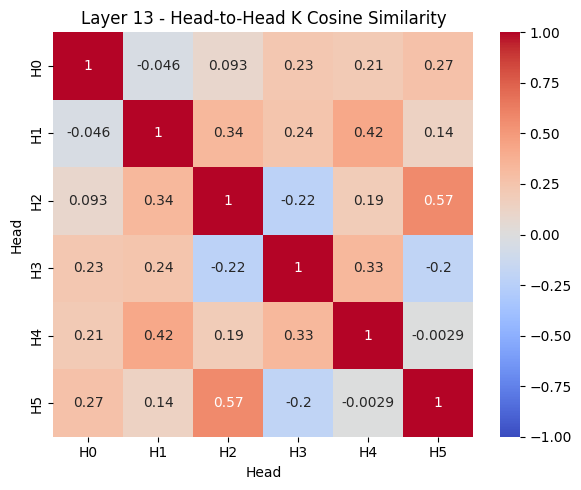

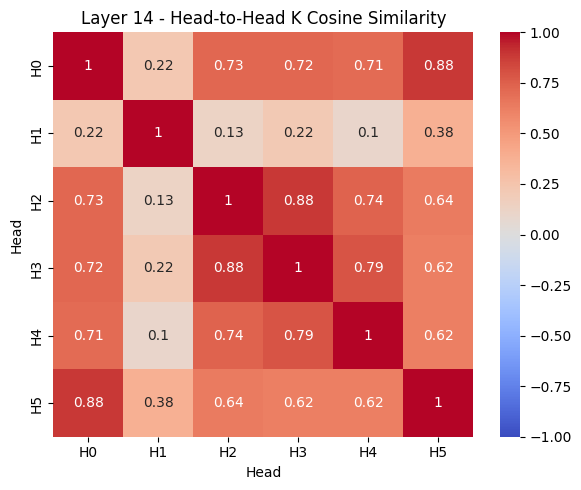

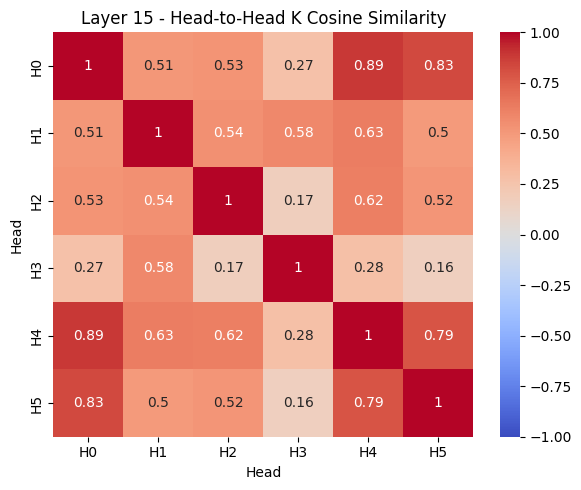

In [ ]:
import random

# Generate a list of unique random numbers
n = 50
examples = random.sample(range(1, 101), n)

total_sim_matrix = []

for idx in examples:
  sample = tokenized_datasets["validation"][idx]
  input_ids = torch.tensor(sample["input_ids"]).unsqueeze(0)
  attention_mask = torch.tensor(sample["attention_mask"]).unsqueeze(0)
  layers_scores = calculate_model_score(model, input_ids, attention_mask)
  sim_matrixs = calc_sim_matrix(layers_scores)
  if total_sim_matrix == []:
    total_sim_matrix = sim_matrixs
  else:
    for mat_idx in range(len(total_sim_matrix)):
      total_sim_matrix[mat_idx] += sim_matrixs[mat_idx]

for mat_idx in range(len(total_sim_matrix)):
  total_sim_matrix[mat_idx] /= len(examples)

plot_layer_head_score_similarity(total_sim_matrix)

Shape of first layer score: torch.Size([1, 6, 125, 125])
Shape of first layer score: torch.Size([1, 6, 361, 361])
Shape of first layer score: torch.Size([1, 6, 430, 430])
Shape of first layer score: torch.Size([1, 6, 289, 289])
Shape of first layer score: torch.Size([1, 6, 259, 259])
Shape of first layer score: torch.Size([1, 6, 601, 601])
Shape of first layer score: torch.Size([1, 6, 89, 89])
Shape of first layer score: torch.Size([1, 6, 399, 399])
Shape of first layer score: torch.Size([1, 6, 779, 779])
Shape of first layer score: torch.Size([1, 6, 113, 113])
Shape of first layer score: torch.Size([1, 6, 307, 307])
Shape of first layer score: torch.Size([1, 6, 216, 216])
Shape of first layer score: torch.Size([1, 6, 626, 626])
Shape of first layer score: torch.Size([1, 6, 540, 540])
Shape of first layer score: torch.Size([1, 6, 583, 583])
Shape of first layer score: torch.Size([1, 6, 1024, 1024])
Shape of first layer score: torch.Size([1, 6, 183, 183])
Shape of first layer score: tor

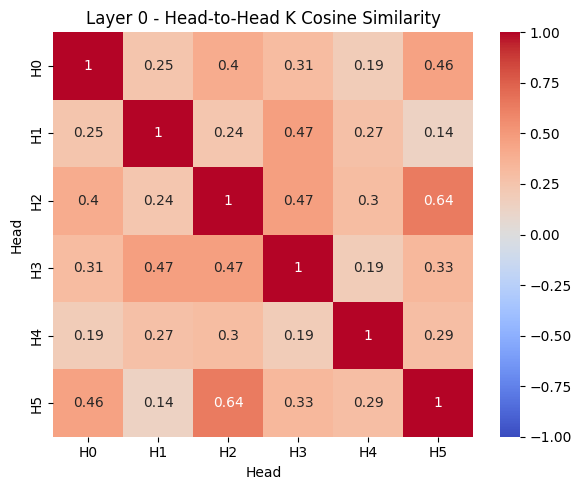

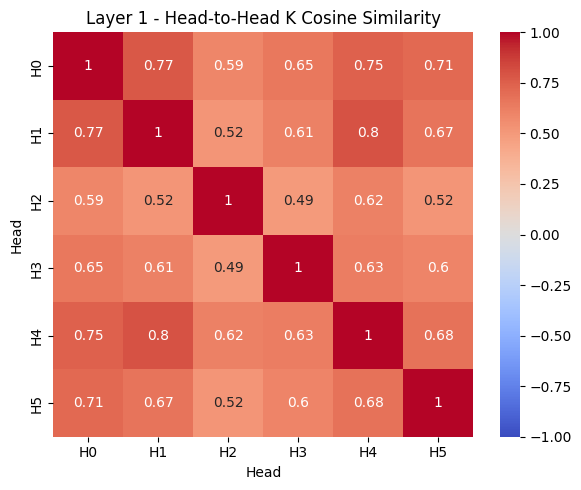

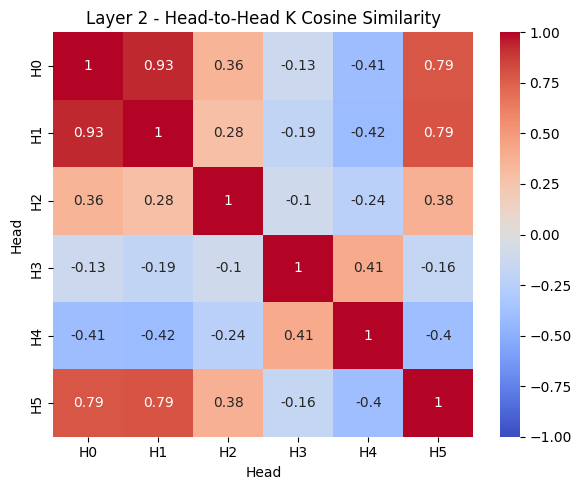

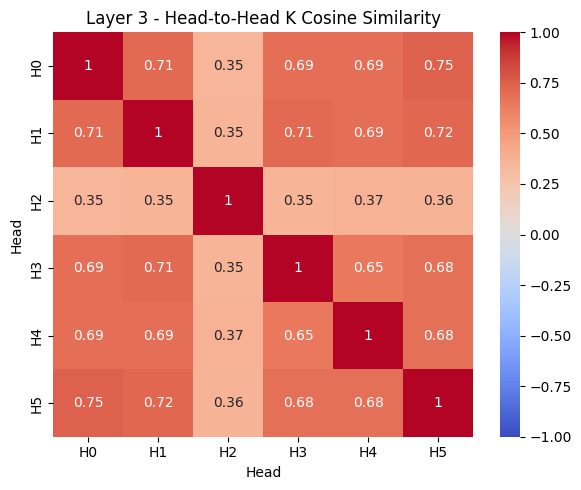

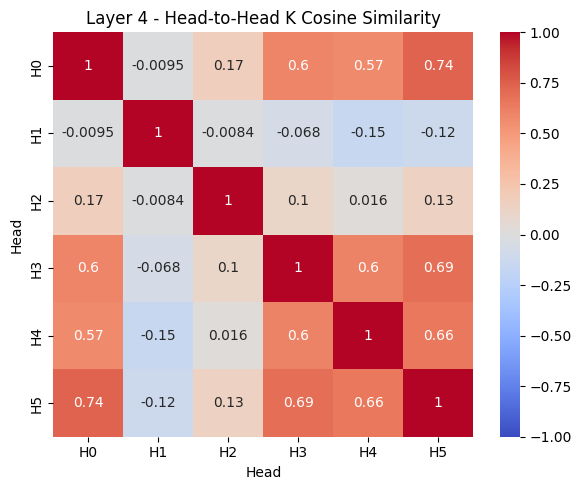

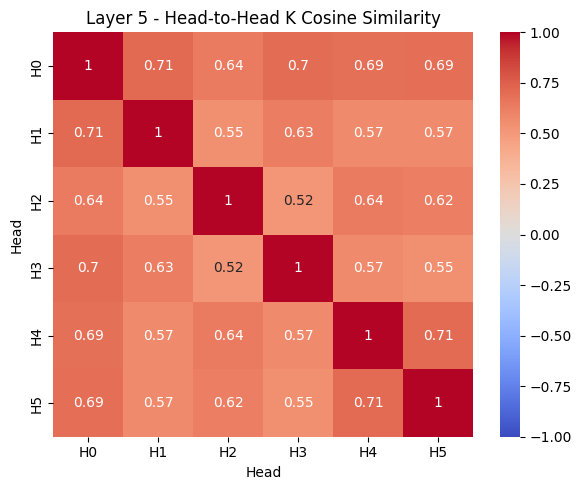

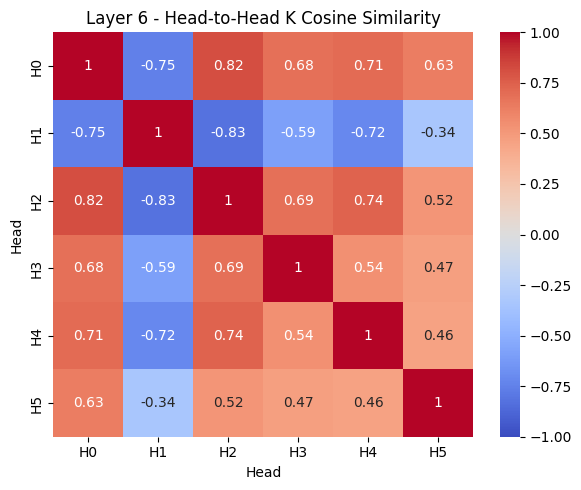

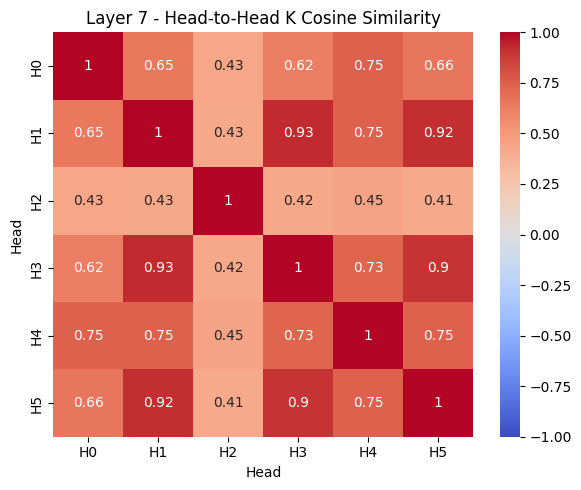

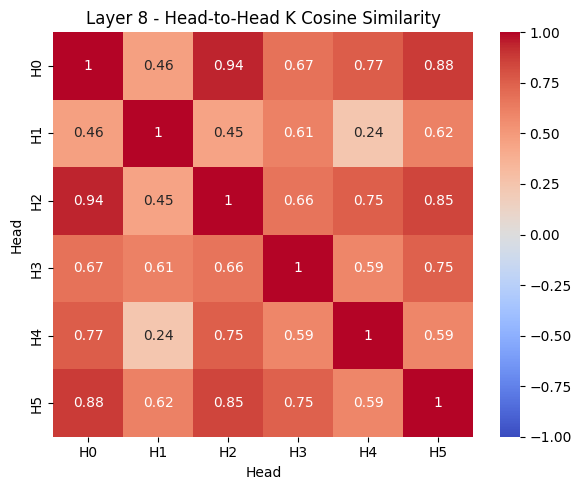

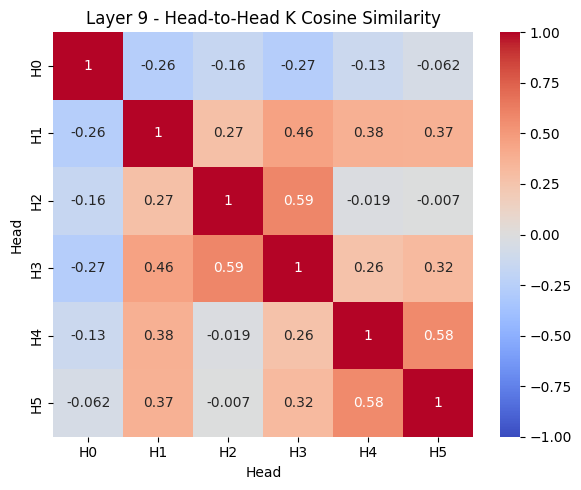

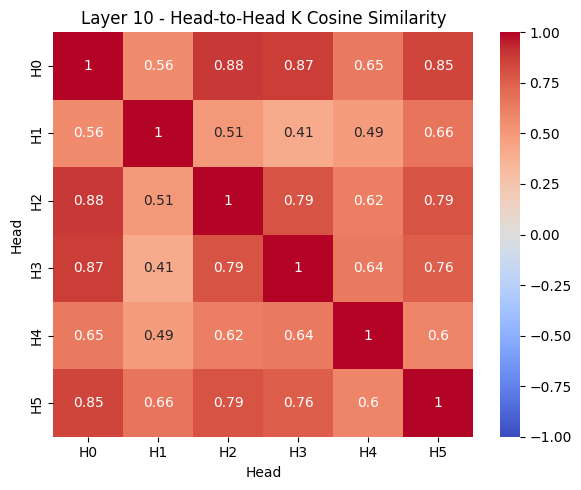

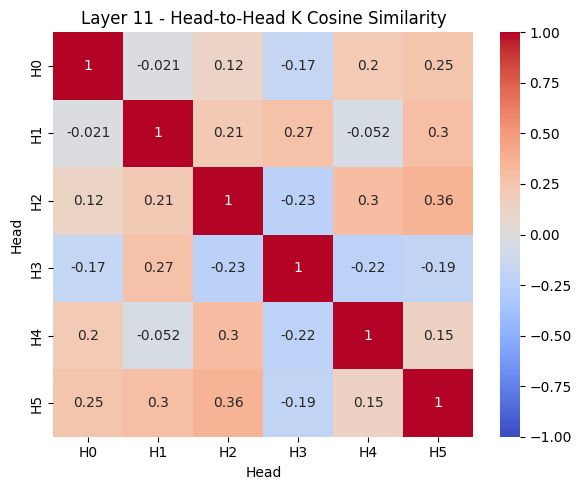

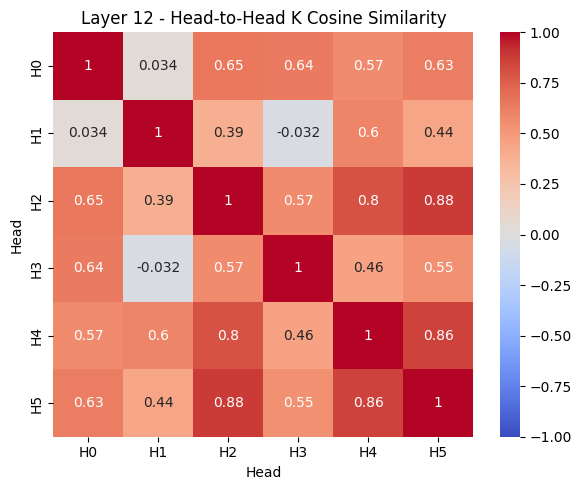

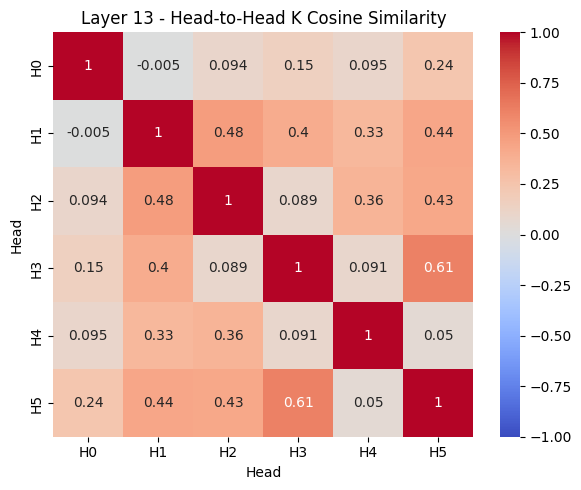

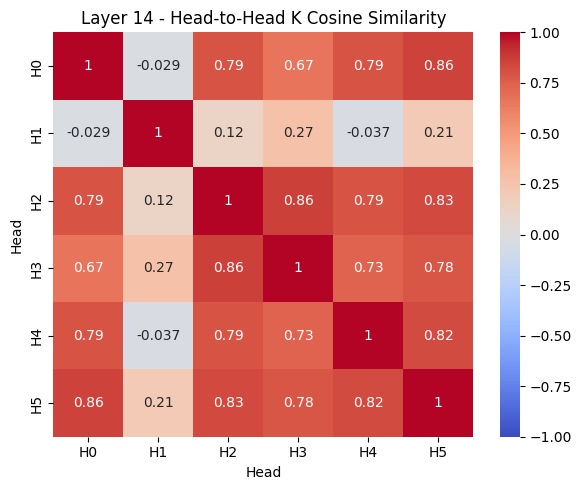

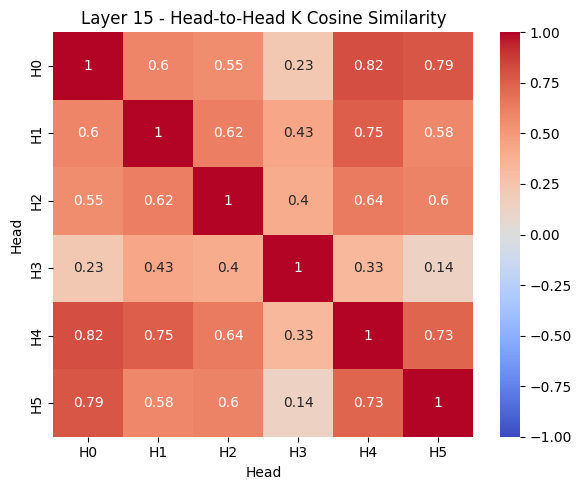

In [ ]:
import random

# Generate a list of unique random numbers
n = 30
examples = random.sample(range(1, 101), n)

total_sim_matrix = []

for idx in examples:
  sample = tokenized_datasets["validation"][idx]
  input_ids = torch.tensor(sample["input_ids"]).unsqueeze(0)
  attention_mask = torch.tensor(sample["attention_mask"]).unsqueeze(0)
  layers_scores = calculate_model_score(model, input_ids, attention_mask)
  sim_matrixs = calc_sim_matrix(layers_scores)
  if total_sim_matrix == []:
    total_sim_matrix = sim_matrixs
  else:
    for mat_idx in range(len(total_sim_matrix)):
      total_sim_matrix[mat_idx] += sim_matrixs[mat_idx]

for mat_idx in range(len(total_sim_matrix)):
  total_sim_matrix[mat_idx] /= len(examples)

plot_layer_head_score_similarity(total_sim_matrix)